In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path_folder=os.path.normcase(r'C:\Users\dell\Downloads\Titanic-maching-learning-from-disaster')
train_data_origin=pd.read_csv(os.path.join(path_folder,'train.csv'),sep=',')
test_data_origin=pd.read_csv(os.path.join(path_folder,'test.csv'),sep=',')

In [3]:
def deal_ticket_fare(df):
    '''
    计算每张票有几人共享，以及每人花费的船票钱
    
    paramters:
        df--dataframe，待处理的数据表
        
    return:
        df_count--处理后，添加新列的数据表
    '''
    num_of_tickets=df[['Ticket']].groupby(df['Ticket']).count()
    num_of_tickets.columns=['num_of_tickets']
    df_count=df.merge(num_of_tickets,left_on='Ticket',right_index=True,how='left')
    df_count['fare_per_ticket']=df_count['Fare']/df_count['num_of_tickets']
    return df_count

In [4]:
# 构造 数据预处理 流水线
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator,TransformerMixin

class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attrs_name_list):
        self.attrs_name_list=attrs_name_list
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X[self.attrs_name_list].values

def data_preparation(cat_attributes,interval_num_attributes,ratio_num_attributes):
    '''
    构造处理DataFrame 的 类
    
    Arguments:
        cat_attributes ---         标称数据列集合
        interval_num_attributes--- 标度数值列集合/不需进行标准化的列集合
        ratio_num_attributes   --- 比例数值列集合/需进行 标准化 列集合
       
    Return 
        full_pipeline---类class
    '''
    cat_attrs=cat_attributes    
    interval_num_attrs=interval_num_attributes
    ratio_num_attrs=ratio_num_attributes
    transformer_list=[]
    
    if cat_attrs:
        cat_pipeline=Pipeline([('cat_dfs',DataFrameSelector(cat_attrs)),('impute',SimpleImputer(strategy='most_frequent')),\
                               ('onehotencoder',OneHotEncoder())])
        transformer_list.append(('cat_pipeline',cat_pipeline))
        
    if interval_num_attrs:
        interval_num_pipeline=Pipeline([('dfs',DataFrameSelector(interval_num_attrs)),('impute',SimpleImputer(strategy='median')) ])
        transformer_list.append(('interval_num_pipeline',interval_num_pipeline))
        
    if ratio_num_attrs:    
        ratio_num_pipeline=Pipeline([('dfs',DataFrameSelector(ratio_num_attrs)),('impute',SimpleImputer(strategy='median')),\
                                     ('std_scaler',StandardScaler())])
        transformer_list.append(('ratio_num_pipeline',ratio_num_pipeline))
    full_pipeline=FeatureUnion(transformer_list=transformer_list)
    return full_pipeline

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    from sklearn.model_selection import learning_curve
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)#train_scores size (n_ticks,n_cv_folds)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 's-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [6]:
# 计算 预测准确率
def compute_acc(y,y_pred):
    y_pred_class=np.where(y_pred>0.5,1,0)
    pred_accuracy=(y==y_pred_class).sum()/len(y)    
    return pred_accuracy

In [8]:
# scale 数值数据 数据预处理
train_data_count=deal_ticket_fare(train_data)
from sklearn.model_selection import train_test_split
#train_data_index,dev_data_index=train_test_split(train_data_count.index.tolist(),train_size=0.7,test_size=0.3,random_state=42)
#train_df_data=train_data_count.iloc[train_data_index,:]
#dev_df_data=train_data_count.iloc[dev_data_index,:]
train_df_data,dev_df_data=train_test_split(train_data_count,train_size=0.7,test_size=0.3,random_state=42)
train_data_index=train_df_data.index.tolist()
dev_data_index=dev_df_data.index.tolist()
cat_attrs=['Sex','Embarked']    
interval_num_attrs=['Pclass','SibSp','Parch','num_of_tickets']
ratio_num_attrs=['Age','Fare','fare_per_ticket']
full_pipeline_std=data_preparation(cat_attrs,interval_num_attrs,ratio_num_attrs)
train_data_X=full_pipeline_std.fit_transform(train_data_count).toarray()
train_data_y=train_data_count['Survived'].values.ravel()
train_data_X[0]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        3.        ,  1.        ,  0.        ,  1.        , -0.56573646,
       -0.50244517, -0.49697568])

In [18]:
joblib.dump(full_pipeline_std,'preparation.joblib')

['preparation.joblib']

In [8]:
dev_data_X=full_pipeline_std.transform(dev_df_data).toarray()
dev_data_y=dev_df_data['Survived'].values.ravel()
dev_data_X[0]

array([ 0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        3.        ,  1.        ,  1.        ,  2.        , -0.0772525 ,
       -0.32547755, -0.49449441])

In [9]:
# 支持向量机 SVM  ----scale 后的数据，模型的性能更好 
#模型训练 交叉验证
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
svm_clf=SVC(C=1,max_iter=5000,gamma='auto',kernel='rbf')
scores=cross_val_score(svm_clf,train_data_X,train_data_y,cv=10)
print (scores.mean())

0.8249145953921234


In [10]:
# dev accuracy 计算
svm_clf.fit(train_data_X,train_data_y)
svm_y_pred=np.where(svm_clf.predict(dev_data_X)>0.5,1,0)
svm_acc=(svm_y_pred==dev_data_y).sum()/len(dev_data_y)
print (svm_acc)

NameError: name 'dev_data_X' is not defined

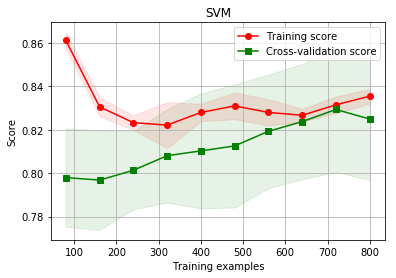

In [11]:
plot_learning_curve(svm_clf,'SVM',train_data_X,train_data_y,cv=10)
plt.show()

In [12]:
from sklearn.model_selection import GridSearchCV
#C_range=[0.0001,0.001,0.01,0.1] #-------------[1]
C_range=[0.001,0.1,1,10,100]        # --------------[2]
#C_range=np.random.randint(1,20,10)
#C_range=list(range(1,10))
degree_range=[2,3,4,5,6,7]
param_grid=[{'kernel':['rbf'] ,'C':C_range,'gamma':['auto','scale']},
            {'kernel':['poly'],'C':C_range,'gamma':['auto','scale'],'degree':degree_range}
           ]
gs_clf=GridSearchCV(estimator=svm_clf,param_grid=param_grid,scoring='accuracy',cv=10,n_jobs=-1,iid=True)

In [13]:
gs_clf.fit(train_data_X,train_data_y)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=5000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'gamma': ['auto', 'scale'], 'C': [0.001, 0.1, 1, 10, 100], 'kernel': ['rbf']}, {'gamma': ['auto', 'scale'], 'degree': [2, 3, 4, 5, 6, 7], 'C': [0.001, 0.1, 1, 10, 100], 'kernel': ['poly']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [14]:
print (gs_clf.best_score_)

0.8282828282828283


In [15]:
gs_clf.best_params_

{'C': 1, 'degree': 4, 'gamma': 'auto', 'kernel': 'poly'}

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


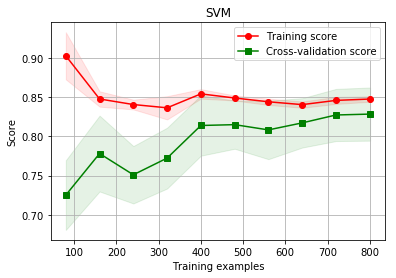

In [16]:
plot_learning_curve(gs_clf.best_estimator_,'SVM',train_data_X,train_data_y,cv=10)
plt.show()

In [17]:
import joblib
joblib.dump(gs_clf.best_estimator_,'SVM.joblib')

['SVM.joblib']

In [17]:
cols=['Sex_T','Embarked_T','Age','Fare','fare_per_ticket','num_of_tickets','Pclass','SibSp','Parch']
train_data_count=deal_ticket_fare(train_data_origin)
train_data_count.reindex(columns=cols).head(1)
#  categorical type data
trans_sex={'male':0,'female':1}
trans_embarked={'S':0,'C':1,'Q':2}

train_data_count['Sex_T']=train_data_count['Sex'].map(trans_sex)
#from sklearn.impute import MissingIndicator
#indicator=MissingIndicator(missing_values=np.nan)
#train_missing_indicator=indicator.fit_transform(train_data_count)
from sklearn.impute import SimpleImputer
imp1=SimpleImputer(missing_values=np.nan,strategy='most_frequent')
train_data_count['Embarked']=imp1.fit_transform(train_data_count[['Embarked']])
imp2=SimpleImputer(missing_values=np.nan,strategy='mean')
train_data_count['Age']=imp2.fit_transform(train_data_count[['Age']])
train_data_count['Embarked_T']=train_data_count['Embarked'].map(trans_embarked).astype(np.int)
cols=['Sex_T','Embarked_T','Age','Fare','fare_per_ticket','num_of_tickets','Pclass','SibSp','Parch']
X_train_data=train_data_count.reindex(columns=cols).values
y_train_data=train_data_count['Survived'].ravel()
values_dict={'Fare':0.0}
test_data_origin.fillna(value=values_dict,inplace=True)
test_data_count=deal_ticket_fare(test_data_origin)
test_data_count['Sex_T']=test_data_count['Sex'].map(trans_sex)
test_data_count['Embarked']=imp1.transform(test_data_count[['Embarked']])
test_data_count['Embarked_T']=test_data_count['Embarked'].map(trans_embarked).astype(np.int)
test_data_count['Age']=imp2.transform(test_data_count[['Age']])
X_test_data=test_data_count.reindex(columns=cols).values

In [18]:
test_data_origin.fillna?

In [8]:
train_data_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
PassengerId        891 non-null int64
Survived           891 non-null int64
Pclass             891 non-null int64
Name               891 non-null object
Sex                891 non-null object
Age                891 non-null float64
SibSp              891 non-null int64
Parch              891 non-null int64
Ticket             891 non-null object
Fare               891 non-null float64
Cabin              204 non-null object
Embarked           891 non-null object
num_of_tickets     891 non-null int64
fare_per_ticket    891 non-null float64
Sex_T              891 non-null int64
Embarked_T         891 non-null int32
dtypes: float64(3), int32(1), int64(7), object(5)
memory usage: 108.0+ KB


In [19]:
test_data_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
PassengerId        418 non-null int64
Pclass             418 non-null int64
Name               418 non-null object
Sex                418 non-null object
Age                418 non-null float64
SibSp              418 non-null int64
Parch              418 non-null int64
Ticket             418 non-null object
Fare               418 non-null float64
Cabin              91 non-null object
Embarked           418 non-null object
num_of_tickets     418 non-null int64
fare_per_ticket    418 non-null float64
Sex_T              418 non-null int64
Embarked_T         418 non-null int32
dtypes: float64(3), int32(1), int64(6), object(5)
memory usage: 47.4+ KB


In [27]:
from sklearn.svm import SVC
clf_svc=SVC(C=1.0,kernel='poly',degree=4,gamma='auto')

In [ ]:
clf_svc.fit(X_train_data,y_train_data)
y_test_pred=((clf_svc.predict(X_test_data).ravel())>0.5).astype(np.int)
test_data_count['Survived']=y_test_pred
test_data_count[['PassengerId','Survived']].to_csv('c:/users/dell/desktop/gender_submission.csv',index=False)